In [21]:
import jax
import jax.numpy as jnp
import numpy as np
import flashbax as fbx
from scipy.stats import norm
import matplotlib.pyplot as plt
import copy
import flashbax
from flashbax.buffers.trajectory_buffer import TrajectoryBufferState

from og_marl.vault_utils.download_vault import *
from og_marl.vault_utils.analyse_vault import *
from flashbax.vault import Vault
import jax
from og_marl.vault_utils.subsample_smaller import subsample_smaller_vault
import seaborn as sns

# Sampling a distribution over return from a dataset of episodes
We need some components:
- Download and unzip the vault (not handled here)
- Load vaults
- Read and process vaults (one at a time so that memory manages) - extract return, episode ends and vault ids
- Process the result more - concatenate, adding episode starts. Then sort by return
- Process into bins. Empty bins are considered

Then we do some magic and find a distribution. Once we have that, in the format of number-of-episodes-to-sample-per-bin, we can:

- Sample idxes per bar
- Do a sanity check to see that the mean and std are the same
- Use those idxes, and the block of info, to backtrack to the vault, select and store the new dataset from the vaults


In [3]:
# just gathering good, medium and poor vaults in a list of unread vaults
def get_all_vaults(rel_dir,vault_name,vault_uids=["Good","Medium","Poor"]):
    vlts = []
    for quality in vault_uids:
        vlts.append(Vault(rel_dir=rel_dir, vault_name=vault_name, vault_uid=quality))
    return vlts

In [22]:
# cumulative summing per-episode
def get_episode_returns_and_term_idxes(vlt):
    all_data = vlt.read()
    offline_data = all_data.experience

    rewards = offline_data['rewards'][0, :, 0]
    terminal_flag = offline_data['terminals'][0, :, ...].all(axis=-1)

    # assert terminal_flag[-1]==True

    def scan_cumsum(return_so_far,prev_term_reward):
        term, reward = prev_term_reward
        return_so_far = return_so_far*(1-term)+ reward
        return return_so_far, return_so_far
    
    xs = (terminal_flag[:-1], rewards[1:])
    
    _, cumsums = jax.lax.scan(scan_cumsum, rewards[0],xs)

    term_idxes = np.argwhere(terminal_flag)

    # shift back as we did for the loop
    return cumsums[term_idxes-1], term_idxes

# first store indices of episodes, then sort by episode return.
# outputs return, start, end and vault index in vault list
def sort_concat(returns,eps_ends, ids):

    episode_start_idxes = eps_ends[:-1]+1
    episode_start_idxes = jnp.insert(episode_start_idxes,0,0).reshape(-1,1)
    sorting_idxes = jnp.lexsort(jnp.array([returns[:,0]]), axis=-1)
    # print(sorting_idxes)

    return_start_end = jnp.concatenate([returns,episode_start_idxes.reshape(-1,1),eps_ends,ids],axis=-1)

    # return, start, end sorted by return value ascending
    sorted_return_start_end = return_start_end[sorting_idxes]
    return sorted_return_start_end

# given bin edges and a sorted array of values, get the bin number per value
def get_bin_numbers(sorted_values,bin_edges):
    bin_numbers = np.zeros_like(sorted_values)
    
    def get_bin_number(bin_num,value):
        is_overflowing = value>bin_edges[bin_num]

        if is_overflowing:
            bin_num += 1
            is_doubly_overflowing = value>bin_edges[bin_num]
            if is_doubly_overflowing:
                bin_num = get_bin_number(bin_num,value)
            
        return bin_num
    
    bin_bookmark = 0

    for i,val in enumerate(sorted_values):
        bin_bookmark = get_bin_number(bin_bookmark,val)
        bin_numbers[i] = bin_bookmark

    return bin_numbers

# sample from pdf according to heights
# BIG NOTE: CHECK THE DISPARITY, OTHERWISE YOUR DISTRIBUTION WILL BE TOO MUCH
def episode_idxes_sampled_from_pdf(pdf,bar_heights):
    num_to_sample = np.round(pdf).astype(int)
    sample_range_edges = np.concatenate([[0],np.cumsum(bar_heights)])

    assert num_to_sample.shape==bar_heights.shape

    target_sample_idxes = []
    for i,n_sample in enumerate(num_to_sample):
            sample_base = np.arange(sample_range_edges[i],sample_range_edges[i+1])
            print(sample_base)
            if n_sample<=0:
                 pass
            # if we sample more than all in the bar
            else:
                if n_sample>=bar_heights[i]:
                    sample_rest = np.random.choice(sample_base,n_sample-bar_heights[i],replace=True)
                    sample = np.concatenate([sample_base,sample_rest])
                else:
                    sample = np.random.choice(sample_base,n_sample,replace=True) #make false for no replace
                target_sample_idxes = target_sample_idxes+list(np.sort(sample))
    return target_sample_idxes

def preprocess(rel_dir,vault_name):
    vlts = get_all_vaults(rel_dir, vault_name)

    # get returns, term idxes for each episode per vault
    returns_list = []
    episode_end_list = []
    vault_ids = []
    for j,vault in enumerate(vlts):
        print(j)
        returns, episode_end_idxes = get_episode_returns_and_term_idxes(vault)
        returns_list.append(returns)
        episode_end_list.append(episode_end_idxes)
        vault_ids.append(jnp.zeros_like(returns)+j)

    # make np compatible
    all_returns = jnp.concatenate(returns_list)
    all_episode_end_idxes = jnp.concatenate(episode_end_list)
    all_vault_ids = jnp.concatenate(vault_ids)

    # concatenate then sort all results
    all_sorted_return_start_end = sort_concat(all_returns,all_episode_end_idxes, all_vault_ids)
    return vlts, all_sorted_return_start_end

def preprocess_vault(rel_dir,vault_name, vault_uid):
    vault = Vault(rel_dir=rel_dir, vault_name=vault_name,vault_uid=vault_uid)

    returns, episode_end_idxes = get_episode_returns_and_term_idxes(vault)
    
    all_sorted_return_start_end = sort_concat(returns,episode_end_idxes, jnp.zeros_like(returns))
    
    return vault, all_sorted_return_start_end

def bin_processed_data(all_sorted_return_start_end, n_bins=500):
    # get bin edges, including final endpoint
    bin_edges = jnp.linspace(start=min(min(all_sorted_return_start_end[:,0]),0), stop = max(all_sorted_return_start_end[:,0]), num=n_bins,endpoint=True)
    print(all_sorted_return_start_end.shape[0])

    # get bin numbers
    bin_numbers = get_bin_numbers(all_sorted_return_start_end[:,0], bin_edges)
    print(bin_numbers.shape[0])

    bar_labels, bar_heights= np.unique(bin_numbers,return_counts=True)

    padded_heights = np.zeros(n_bins)
    for bar_l, bar_h in zip(bar_labels,bar_heights):
        padded_heights[int(bar_l)] = bar_h

    return bar_labels, bar_heights, padded_heights, bin_edges, bin_numbers


def get_idxes_of_similar_subsets(base_returns, comp_returns, tol=0.1):
    base_selected_idxes = []
    comp_selected_idxes = []

    comp_idx = 0

    for i, ret in enumerate(base_returns):
        # print("Run "+str(i))
        ret_dealt_with = False
        while comp_idx<len(comp_returns) and (comp_returns[comp_idx]<=(ret+tol)) and not ret_dealt_with:
            # check comp is in bracket below
            if np.abs((ret-comp_returns[comp_idx]))<tol:
                base_selected_idxes.append(i)
                comp_selected_idxes.append(comp_idx)
                ret_dealt_with = True
            comp_idx+= 1

    return base_selected_idxes, comp_selected_idxes

def stitch_vault_from_sampled_episodes_(vlts, return_start_end_sample, vault_name, vault_uid):

    all_data = vlts[0].read()
    offline_data = all_data.experience

    dest_buffer = fbx.make_trajectory_buffer(
        # Sampling parameters
        sample_batch_size=1,
        sample_sequence_length=1,
        period=1,
        # Not important in this example, as we are not adding to the buffer
        max_length_time_axis=500_000,
        min_length_time_axis=100,
        add_batch_size=1,
    )

    dummy_experience = jax.tree_map(lambda x: x[0, 0, ...], all_data.experience)
    del offline_data
    del all_data

    dest_state = dest_buffer.init(dummy_experience)
    buffer_add = jax.jit(dest_buffer.add, donate_argnums=0)
    dest_vault = flashbax.vault.Vault(
        experience_structure=dest_state.experience,
        vault_name=vault_name,
        vault_uid=vault_uid,
    )

    for vault_id, vlt in enumerate(vlts):
        samples_frm_this_vault = return_start_end_sample[np.where(return_start_end_sample[:,-1]==vault_id)]
        starts = samples_frm_this_vault[:,1]
        ends = samples_frm_this_vault[:,2]

        all_data = vlt.read()
        offline_data = all_data.experience

        for start,end in zip(starts,ends):
            sample_experience = jax.tree_util.tree_map(lambda x: x[:,int(start):int(end+2),...],offline_data)
            dest_state = buffer_add(dest_state, sample_experience)
        
        timesteps_written = dest_vault.write(dest_state)

        print(timesteps_written)
        del offline_data
        del all_data     
    return 
        

In [23]:
def sanity_check(sampled_idxes,returns):
    vals = np.array([returns[i] for i in sampled_idxes])
    return np.mean(vals), np.std(vals)

# Main: for plugging different datasets and playing
Here, we use the above. We:
- Preprocess datasets
- Bin them etc
- Figure out distribution
- Package them again

## Preprocess and bin

In [6]:
source = 'og_marl'
env = 'smac_v1'
task = '2s3z'

rel_vault_location = download_and_unzip_vault(source,env,task)
vault_uids = get_available_uids(rel_vault_location)

[==================================================]

In [7]:
vault_rel_dir = f"vaults/{source}/{env}" # combine base vault directory with the dataset source and environment folders
vault_name = f"{task}.vlt" # a vault name contains only the file name which has the .vlt extension
vault_uid = vault_uids[0] # we select the first dataset in the vault

vlt = Vault(rel_dir=vault_rel_dir, vault_name=vault_name, vault_uid=vault_uid)

Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/og_marl/smac_v1/2s3z.vlt/Poor


In [9]:
vlt_orig, vltorig_sorted_return_start_end = preprocess(rel_dir=vault_rel_dir, vault_name=vault_name)

vlt_good, vltgood_sorted_return_start_end = preprocess_vault(rel_dir=vault_rel_dir, vault_name=vault_name,vault_uid='Good')
vlt_med, vltmed_sorted_return_start_end = preprocess_vault(rel_dir=vault_rel_dir, vault_name=vault_name,vault_uid='Medium')
vlt_poor, vltpoor_sorted_return_start_end = preprocess_vault(rel_dir=vault_rel_dir, vault_name=vault_name,vault_uid='Poor')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/og_marl/smac_v1/2s3z.vlt/Good
Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/og_marl/smac_v1/2s3z.vlt/Medium
Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/og_marl/smac_v1/2s3z.vlt/Poor
0
1
2
Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/og_marl/smac_v1/2s3z.vlt/Good
Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/og_marl/smac_v1/2s3z.vlt/Medium
Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/og_marl/smac_v1/2s3z.vlt/Poor


47163
47163


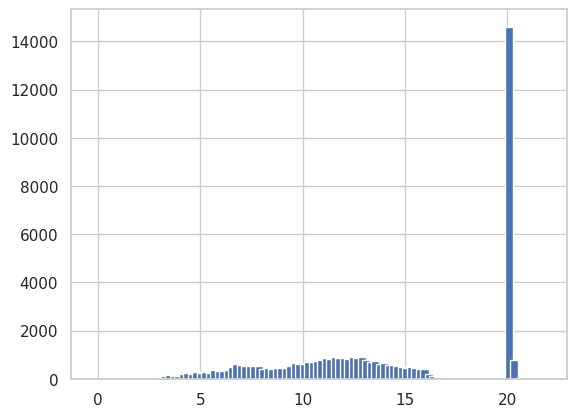

18616
18616


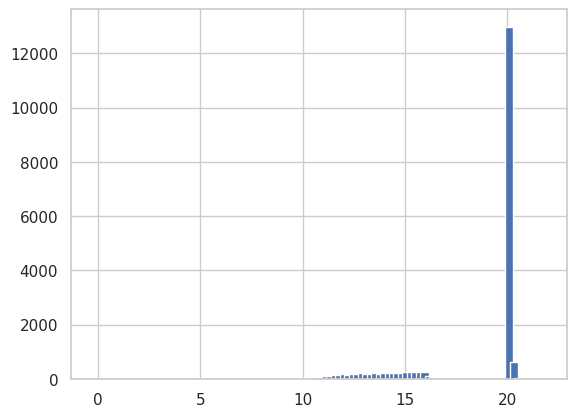

18605
18605


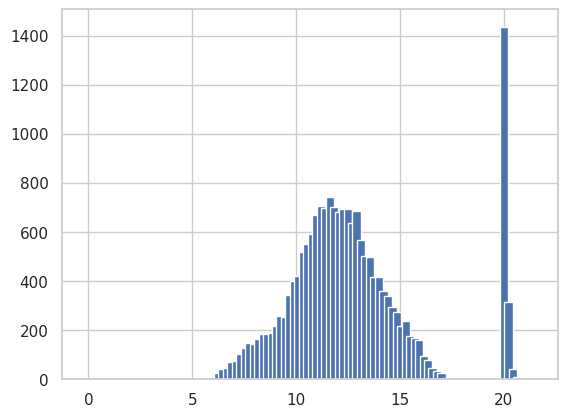

9942
9942


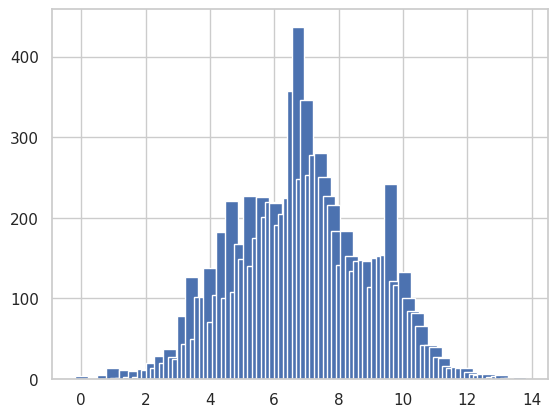

In [24]:
# make histograms of each and recombined maybe 
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()

for metadata in [vltorig_sorted_return_start_end,vltgood_sorted_return_start_end,vltmed_sorted_return_start_end,vltpoor_sorted_return_start_end]:

    bar_labels, bar_heights, padded_heights, bin_edges, bin_numbers = bin_processed_data(metadata, n_bins=100)
    plt.bar(bin_edges,padded_heights,width=0.4)
    # plt.xlim(-0.5,20.5)
    # plt.ylim(0,15000)
    plt.show()

In [35]:
vlt_1, vlt1_sorted_return_start_end = preprocess_vault(rel_dir=vault_rel_dir, vault_name=vault_name, vault_uid = "Medium")
vlt_2, vlt2_sorted_return_start_end = preprocess_vault(rel_dir=vault_rel_dir, vault_name=vault_name, vault_uid="cfcql_Medium")

Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/smac_v1/5m_vs_6m.vlt/Medium
Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/smac_v1/5m_vs_6m.vlt/cfcql_Medium


39284
39284


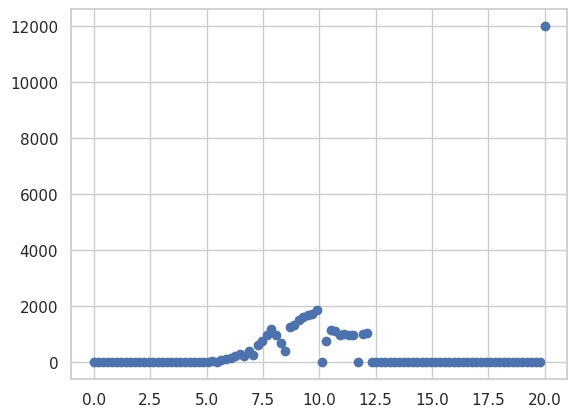

[    1     1     1     2     6    12    15    35    14    73    97   126
   211   297   205   381   266   615   761   976  1178   968   666   397
  1238  1341  1518  1617  1698  1732  1844     1   764  1155  1103   978
  1008   963   963  1019  1021 12017]


In [36]:
bar_labels, bar_heights, padded_heights, bin_edges, bin_numbers = bin_processed_data(vlt1_sorted_return_start_end, n_bins=100)
plt.scatter(bin_edges,padded_heights)
plt.show()
print(bar_heights)

In [39]:
base_ret = vlt1_sorted_return_start_end[:,0]
comp_ret = vlt2_sorted_return_start_end[:,0]

b,c = get_idxes_of_similar_subsets(base_ret,comp_ret,tol=0.01)
print(len(b))

4992


In [42]:
d1_samples = vlt1_sorted_return_start_end[b,:]
d2_samples = vlt2_sorted_return_start_end[c,:]

vault_name = "medium_similar"
sample_experience = stitch_vault_from_sampled_episodes_([vlt_1],d1_samples,vault_name,"Medium_OG_MARL")

New vault created at /home/louise/workspace/og-marl/development/clean_utils/vaults/medium_similar/Medium_OG_MARL
Since the provided buffer state has a temporal dimension of 500000, you must write to the vault at least every 499999 timesteps to avoid data loss.
134985


Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/medium_similar/Medium_OG_MARL
Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/medium_similar/Medium_CFCQL


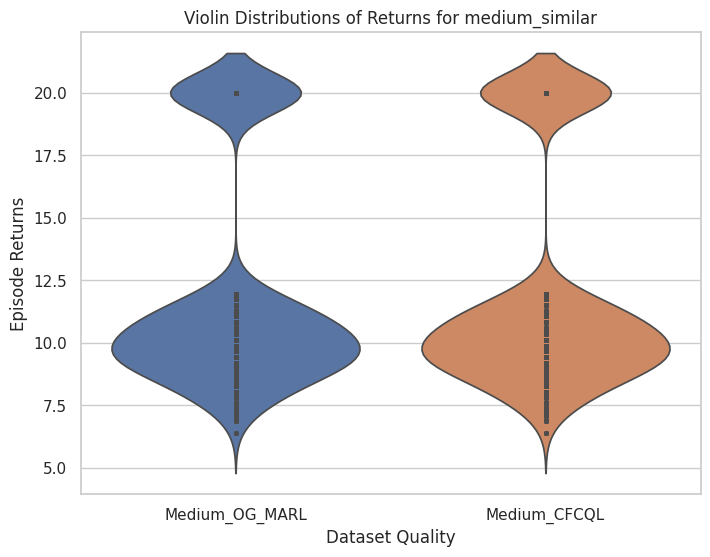

In [43]:
from og_marl.vault_utils.analyse_vault import analyse_vault

returns = analyse_vault("medium_similar", visualise=True)
# analyse_vault("cherry", visualise=True)

In [ ]:
# get base vaults
rel_dir = "vaults/"
new_vault_name = "medium_similar_120000"

vlt_1, vlt1_sorted_return_start_end = preprocess_vault(rel_dir=rel_dir, vault_name=new_vault_name, vault_uid = "Medium")
vlt_2, vlt2_sorted_return_start_end = preprocess_vault(rel_dir=rel_dir, vault_name=new_vault_name, vault_uid="cfcql_Medium")